In [ ]:
'''У нас имеется база данных в кикхаусе, куда ежедневно записываются данные по пользователям ленты новостей.
Лента новостей представляет из себя посты с возможностью их просматривать, лайкать, и также отправлять сообщения
друг другу. Действия по ленте новостей это like и view, действия по месссенджеру заполняются отдельной схемой в БД
и включают просто сообщения, кому и когда. В целом, лента и мессенджер составляют некое приложение, которое мы 
хотим развивать, наполняя новыми пользователями и поддерживая их активность.'''

In [ ]:
'''
 Команда маркетологов решила организовать флэшмоб в ленте новостей:
участники должны сделать пост, где они рассказывают какой-то интересный факт о себе, 
и опубликовать его с хэштегом. Три поста, собравших наибольшее число лайков, получают призы.

 Флэшмоб проходил с 2025-01-17 по 2025-01-23. 
Ваша задача как аналитика – оценить эффективность этого мероприятия с помощью CausalImpact.
 Как работает:
Строит модель, предсказывающую целевую переменную на основе исторических данных до вмешательства.
Сравнивает прогноз с реальными данными после вмешательства.
Рассчитывает эффект (разницу) и его статистическую значимость.'''

In [ ]:
Очевидно что флешмоб, при условии что он сработал, вызовет изменение в таких метриках как просмотры,
лайки, CTR, количество уникальных пользователей.

In [ ]:
# Импорт необходимых библиотек для работы и самого пакета CausalImpact
import tensorflow as tf # Библиотека для машинного обучения 
import tensorflow_probability as tfp #  Расширение TensorFlow для вероятностного машинного обучения 
from causalimpact import CausalImpact                      # и статистического анализа.
#общие штуки для кручения данных
import pandas as pd
import pandahouse as ph
#общие штуки для рисования
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Строка подключения к кликхаус
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20250120',
    'user':'student',
    'password':'dpo_python_2020'}
# Запрос исходной таблицы ленты новостей из БД для понимания структуры таблицы
feed = """
SELECT *
FROM {db}.feed_actions 
WHERE toDate(time) >= toDate('2025-01-03') and toDate(time) < toDate('2025-01-04')"""

In [3]:
# Наша исходная таблица ленты новостей
df_table_feed = ph.read_clickhouse(feed, connection=connection)
df_table_feed.head(5)

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group
0,12827,2004,like,2025-01-03 00:00:00,1,43,Turkey,İzmir,Android,ads,2
1,20565,1942,like,2025-01-03 00:00:00,0,23,Russia,Moscow,iOS,ads,4
2,114053,1915,view,2025-01-03 00:00:00,1,56,Russia,Kirov,Android,organic,3
3,115273,1984,view,2025-01-03 00:00:00,1,21,Russia,Moscow,iOS,organic,3
4,122707,1850,view,2025-01-03 00:00:01,1,25,Russia,Mirnyy,iOS,organic,1


In [3]:
# Запросим из кликхауса CTR, view, like, DAU, post
query = '''
SELECT 
    toDate(time) as date,
    countIf(action = 'like')/countIf(action = 'view') as CTR,
    countIf(action = 'view') as view,
    countIf(action = 'like') as like,
    count(distinct user_id) as DAU,
    count(distinct post_id) as post
FROM 
    simulator_20250120.feed_actions
WHERE date >= toDateTime('2024-12-07')
  AND date <= toDateTime('2025-01-23')
GROUP BY date
ORDER BY 
    date
'''
# Помещаем данные в df
df_metric = ph.read_clickhouse(query, connection=connection)
df_metric.set_index('date', inplace=True, drop=False) # сделаем столбец индекса как дату - нужно для модели
df_metric.head(4)

,date,CTR,view,like,DAU,post
date,,,,,,
2024-12-07,2024-12-07,0.205182,7603,1560,878,89
2024-12-08,2024-12-08,0.204174,62770,12816,2238,178
2024-12-09,2024-12-09,0.198605,105526,20958,3105,191
2024-12-10,2024-12-10,0.200007,118996,23800,3721,211


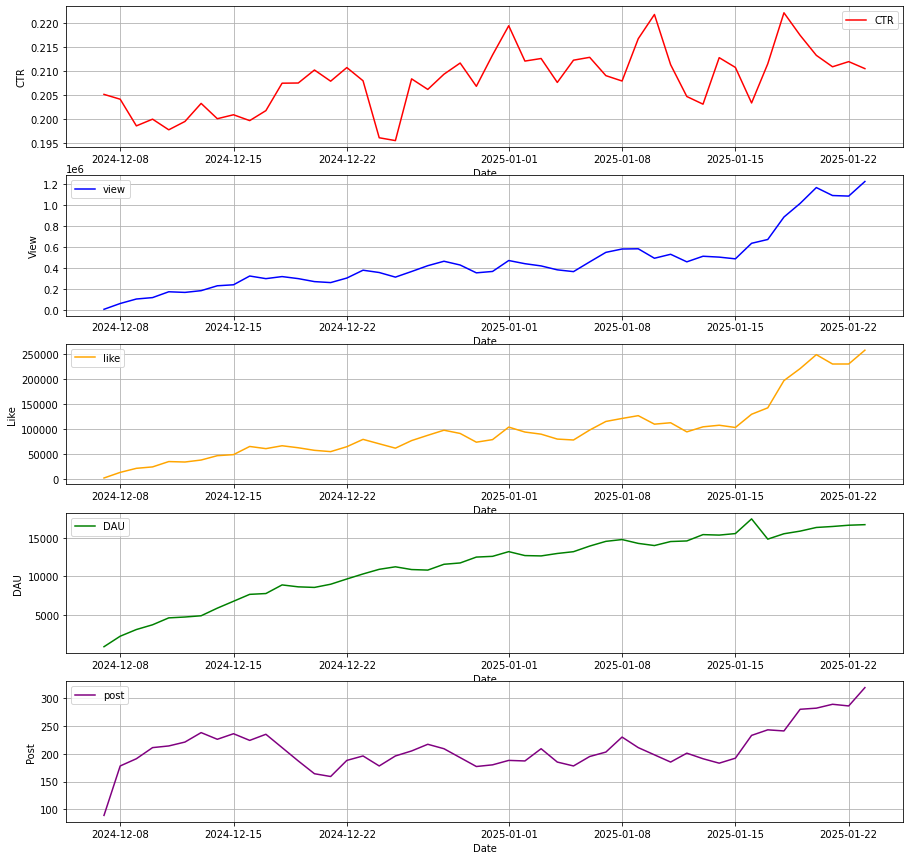

In [4]:
# Посмотрим на наши метрики
fig, axes = plt.subplots(5, 1, figsize=(15, 15))
axes[0].plot(df_metric.date, df_metric.CTR, color='red', label='CTR')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('CTR')
axes[0].grid(True)
axes[0].legend()
axes[1].plot(df_metric.date, df_metric.view, color='blue', label='view')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('View')
axes[1].grid(True)
axes[1].legend()
axes[2].plot(df_metric.date, df_metric.like, color='orange', label='like')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Like')
axes[2].grid(True)
axes[2].legend()
axes[3].plot(df_metric.date, df_metric.DAU, color='green', label='DAU')
axes[3].set_xlabel('Date')
axes[3].set_ylabel('DAU')
axes[3].grid(True)
axes[3].legend()
axes[4].plot(df_metric.date, df_metric.post, color='purple', label='post')
axes[4].set_xlabel('Date')
axes[4].set_ylabel('Post')
axes[4].grid(True)
axes[4].legend()

In [ ]:
CTR - очевидно не имеет никакого тренда, как и Post - в начале запуска приложения есть рост,
но в целом метрика заняла плато. Like и DAU имеют глобальный растущий тренд.

In [16]:
df_model = df_metric.drop('date', axis=1) # Удалим столбец даты, т.к. у нас дата это индекс 
df_model = df_model.asfreq('D') # Заполнит пропуски в датах Nan, если имеются 

In [19]:
# Создаем тренд с помощью моуля sts (структурная модель временных рядов)
trend = tfp.sts.LocalLinearTrend(observed_time_series=df_model)
# Если есть недельная сезонность:
seasonal = tfp.sts.Seasonal(num_seasons=7, observed_time_series=df_model)
model = tfp.sts.Sum([trend, seasonal], observed_time_series=df_model)

In [20]:
# Определеим препериод как все наши данные, а пост период как период флешмоба.
pre_period = [pd.Timestamp('2024-12-07'), pd.Timestamp('2025-01-16')]
post_period = [pd.Timestamp('2025-01-17'), pd.Timestamp('2025-01-23')]

In [ ]:
'''Определим нашу модель для просмотров'''
impact_view = CausalImpact(data=df_metric.view,  # данные
                         pre_period=pre_period,  # период до события
                         post_period=post_period,# период флешмоба (после события)
                         alpha=0.05,             # уровень значимости
                         model_args={
        'niter': 2000,          # Количество итераций MCMC
        'prior_level_sd': 0.1, # Стандартное отклонение априорного распределения для уровня тренда
        'model': model          # Передаем нашу модель c сезонностью
    }) 

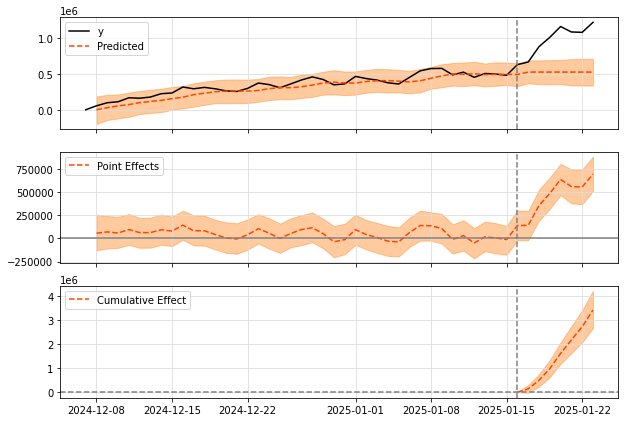

In [39]:
impact_view.plot()

In [40]:
# Отчёт о величине и статзначимости эффекта и интерпретация
print(impact_view.summary(), impact_view.summary('report'))

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1019947.31         7139631.0
Prediction (s.d.)         532187.56 (56259.64)3725313.0 (393817.48)
95% CI                    [423763.42, 644297.19][2966343.89, 4510080.36]

Absolute effect (s.d.)    487759.75 (56259.64)3414318.0 (393817.48)
95% CI                    [375650.13, 596183.9][2629550.64, 4173287.11]

Relative effect (s.d.)    91.65% (10.57%)    91.65% (10.57%)
95% CI                    [70.59%, 112.03%]  [70.59%, 112.03%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report')) Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 1019947.31. By contrast, in the absence of an
intervention, we would have expected an average response of 532187.56.
The 95% interval of this counterfactual prediction is [

In [ ]:
'''Отчет говорит нам о статистически значимом эффекте - количество просмотров увеличилось на 91%'''

In [ ]:
'''Определим модель для лайков'''
impact_like = CausalImpact(data=df_metric.like,  # данные
                         pre_period=pre_period,  # период до события
                         post_period=post_period,# период флешмоба (после события)
                         alpha=0.05,             # уровень значимости
                         model_args={
        'niter': 2000,          # Количество итераций MCMC
        'prior_level_sd': 0.1, # Стандартное отклонение априорного распределения для уровня тренда 0...1
        'model': model          # Передаем нашу модель c сезонностью
    }) 

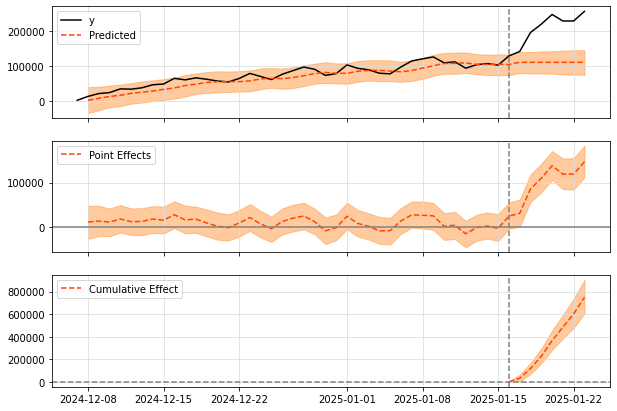

In [42]:
impact_like.plot()

In [43]:
print(impact_like.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    218090.14          1526631.0
Prediction (s.d.)         111112.48 (10429.03)777787.38 (73003.23)
95% CI                    [90468.68, 131349.74][633280.74, 919448.2]

Absolute effect (s.d.)    106977.66 (10429.03)748843.62 (73003.23)
95% CI                    [86740.4, 127621.46][607182.8, 893350.26]

Relative effect (s.d.)    96.28% (9.39%)     96.28% (9.39%)
95% CI                    [78.07%, 114.86%]  [78.07%, 114.86%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [ ]:
'''Апостериорная вероятность эффекта (а не случайности) 100%, Эффект по лайкам тоже статистически занчимый +96%
Байесовская вероятность апостериорной хвостовой области - это вероятность получить эффект случайно, или что
эфект не от нашего воздействия
   '''

In [ ]:
'''Определим модель для количества пользователей'''
impact_DAU = CausalImpact(data=df_metric.DAU,  # данные
                         pre_period=pre_period,  # период до события
                         post_period=post_period,# период флешмоба (после события)
                         alpha=0.05,             # уровень значимости
                         model_args={
        'niter': 2000,          # Количество итераций MCMC
        'prior_level_sd': 0.1, # Стандартное отклонение априорного распределения для уровня тренда
        'model': model          # Передаем нашу модель c сезонностью
    }) 

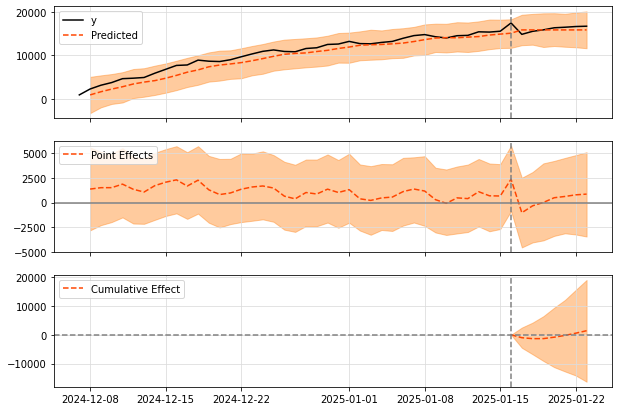

In [37]:
impact_DAU.plot()

In [44]:
print(impact_DAU.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    16052.71           112369.0
Prediction (s.d.)         15851.75 (1318.81) 110962.22 (9231.64)
95% CI                    [13317.54, 18487.16][93222.76, 129410.12]

Absolute effect (s.d.)    200.97 (1318.81)   1406.78 (9231.64)
95% CI                    [-2434.45, 2735.18][-17041.12, 19146.24]

Relative effect (s.d.)    1.27% (8.32%)      1.27% (8.32%)
95% CI                    [-15.36%, 17.25%]  [-15.36%, 17.25%]

Posterior tail-area probability p: 0.45
Posterior prob. of a causal effect: 54.67%

For more details run the command: print(impact.summary('report'))


In [ ]:
'''
The probability of obtaining this effect by chance is p = 45.33%.
This means the effect may be spurious and would generally not be
considered statistically significant.
Вероятность получения эффекта для DAU случайно - 45%, и сам эффект очень небольшой 1.3%, не статзначимый.''' 

In [ ]:
'''Определим модель для количества постов, нашу сезонность для постов не будемвключать
поскольку она не очевидна'''
impact_post = CausalImpact(data=df_metric.post,  # данные
                         pre_period=pre_period,  # период до события
                         post_period=post_period,# период флешмоба (после события)
                         alpha=0.05,             # уровень значимости
                         model_args={
        'niter': 2000,          # Количество итераций MCMC
        'prior_level_sd': 0.1, # Стандартное отклонение априорного распределения для уровня тренда
                  
    }) 

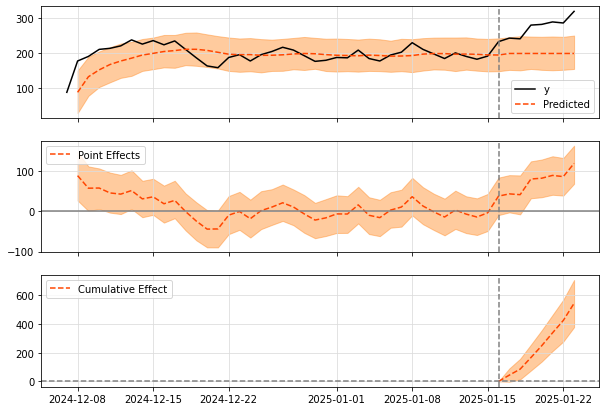

In [49]:
impact_post.plot()

In [51]:
print(impact_post.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    277.14             1940.0
Prediction (s.d.)         199.39 (12.42)     1395.7 (86.94)
95% CI                    [174.92, 223.61]   [1224.43, 1565.24]

Absolute effect (s.d.)    77.76 (12.42)      544.3 (86.94)
95% CI                    [53.54, 102.22]    [374.76, 715.57]

Relative effect (s.d.)    39.0% (6.23%)      39.0% (6.23%)
95% CI                    [26.85%, 51.27%]   [26.85%, 51.27%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [ ]:
''' Количество постов имеет статистически значимый эффект +39%'''

In [ ]:
'''Определим модель для CTR,сезонность не будем включать
поскольку она не очевидна'''
impact_CTR = CausalImpact(data=df_metric.CTR,  # данные
                         pre_period=pre_period,  # период до события
                         post_period=post_period,# период флешмоба (после события)
                         alpha=0.05,             # уровень значимости
                         model_args={
        'niter': 2500,          # Количество итераций MCMC
        'prior_level_sd': 0.85,  # Стандартное отклонение априорного распределения для уровня тренда
                                # чем болше тем модель позволяет меняться тренду более быстро
    }) 

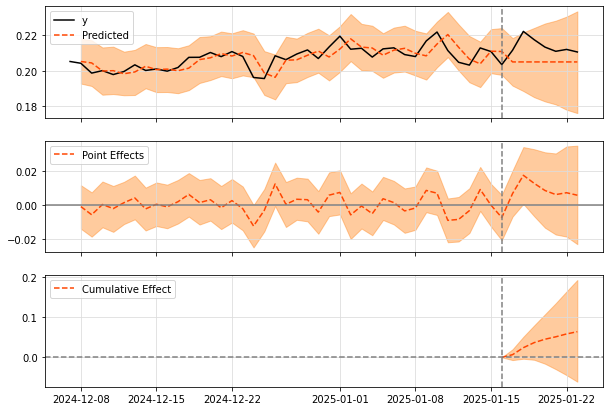

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.21               1.5
Prediction (s.d.)         0.2 (0.01)         1.43 (0.06)
95% CI                    [0.19, 0.22]       [1.32, 1.56]

Absolute effect (s.d.)    0.01 (0.01)        0.06 (0.06)
95% CI                    [-0.01, 0.03]      [-0.06, 0.18]

Relative effect (s.d.)    4.44% (4.27%)      4.44% (4.27%)
95% CI                    [-4.1%, 12.64%]    [-4.1%, 12.64%]

Posterior tail-area probability p: 0.15
Posterior prob. of a causal effect: 84.69%

For more details run the command: print(impact.summary('report'))


In [72]:
impact_CTR.plot()
print(impact_CTR.summary())

In [ ]:
'''
CTR - хотя метрика имеет некоторый положительный эффект 4.4% - но вероятность получить его случайно 15% 
поэтому такой результат не знпчим
Таким образом мы посмотрели все метрики и выяснили какие из них имели статистически значимыеэффекты.'''